# Getting some quick picks for 2023-04-08

http://ufcstats.com/event-details/3dc3022232b79c7a

https://www.bestfightodds.com/events/ufc-287-2760

Unfortunately I forgot to run the full script prior to this, so it's a bit jank

In [1]:
import sys
sys.path.append('/Users/john/play/sports/') # add parent directory to path

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from db import base_db_interface

df = base_db_interface.read("bfo_espn_ufc_features")
for dt_col in ["Date", "DOB", "DOB_opp"]:
    df[dt_col] = pd.to_datetime(df[dt_col])
df[["FighterOpen", "OpponentOpen"]] = df[["FighterOpen", "OpponentOpen"]]\
    .astype(float)

df = df.drop_duplicates(subset=["FighterID_espn", "OpponentID_espn", "fight_id"])
df["FighterID_espn"] = df["FighterID_espn"].fillna("unknown")
df["OpponentID_espn"] = df["OpponentID_espn"].fillna("unknown")
print(df.shape)
df.head() # show the first 5 rows

(132600, 249)


,fight_id,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,prev_weight,FighterID_espn_opp,n_career_fights_opp,n_ufc_fights_opp,t_since_first_fight_opp,t_since_prev_fight_opp,total_ufc_cage_time_opp,min_weight_opp,max_weight_opp,prev_weight_opp
0,1991-09-26_2354059_2558095,1991-09-26,L,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2354059,2558095,NaN,...,NaN,2354059,0,0,0,NaN,0.0,185.0,185.0,NaN
1,1991-09-26_2354059_2558095,1991-09-26,W,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2558095,2354059,NaN,...,NaN,2558095,0,0,0,NaN,0.0,NaN,NaN,NaN
2,1992-01-01_2354119_2501396,1992-01-01,W,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2501396,2354119,NaN,...,NaN,2501396,0,0,0,NaN,0.0,185.0,185.0,NaN
3,1992-01-01_2354119_2501396,1992-01-01,L,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2354119,2501396,NaN,...,NaN,2354119,0,0,0,NaN,0.0,170.0,170.0,NaN
4,1993-08-29_2354132_3107994,1993-08-29,L,Submission (Strikes),1,2:46,CP X CB: Capoeira vs. Chute Boxe,2354132,3107994,NaN,...,NaN,2354132,0,0,0,NaN,0.0,170.0,170.0,NaN


In [3]:
from sklearn.decomposition import PCA
# OKAY PCA HAPPENS HERE. Just do everything in-sample for now. 
stat_cols = [
    'TSL', 'TSA', 'SSL',
    'SSA', #'TSL-TSA', 
    'KD', #'%BODY', '%HEAD', '%LEG', 
    'SCBL',
    'SCBA', 'SCHL', 'SCHA', 'SCLL', 'SCLA', 'RV', 'TDL', 'TDA', 'TDS',
    # 'TK ACC', 'SR', # I don't believe in ratio features in PCA, 
    # # because of the possibility of division by zero and heteroskedasticity
    'SGBL', 'SGBA', 'SGHL', 'SGHA', 'SGLL', 'SGLA', 'AD', 'ADTB',
    'ADHG', 'ADTM', 'ADTS', 'SM', 'SDBL', 'SDBA', 'SDHL',
    'SDHA', 'SDLL', 'SDLA',
    #'time_seconds',
    # 'TD_fails', #'submission_rate',
    'TD_fail', # formerly 'TD_fails'
    'SDL', 'SCL', # formerly 'distance_strikes_landed', 'clinch_strikes_landed',
    #'KD_power', 
    'SGL', # formerly 'ground_strikes_landed'
]
df[["KD", "KD_opp"]] = df[["KD", "KD_opp"]].astype(float) 
# convert from string to float. rather annoying

In [4]:
stat_diff_df = {
    "FighterID_espn": df["FighterID_espn"],
    "OpponentID_espn": df["OpponentID_espn"],
    "Date": df["Date"],
    "gender": df["gender"],
    "fight_id": df["fight_id"],
}
diff_cols = [col+"_diff" for col in stat_cols]
for col, diff_col in zip(stat_cols, diff_cols):
    stat_diff_df[diff_col] = (
        np.sqrt(df[col]) - np.sqrt(df[col+"_opp"])
    )
# stat_diff_df = pd.DataFrame(stat_diff_df).dropna(subset=diff_cols).reset_index()
stat_diff_df = pd.DataFrame(stat_diff_df).reset_index()

# Elo estimators

In [5]:
n_pca = 14
# n_pca = 1 # just for testing
bin_elo_alpha = 0.45
acc_elo_alpha = 0.45
pca_elo_alpha = 0.45
real_elo_alpha = 0.45

In [6]:
from importlib import reload

import model.mma_elo_model as mma_elo_model
reload(mma_elo_model)

import model.mma_features as mma_features
reload(mma_features)

<module 'model.mma_features' from '/Users/john/play/sports/model/mma_features.py'>

In [7]:
from model.mma_features import PcaEloWrapper, BinaryEloWrapper

pca_ew = PcaEloWrapper(
    n_pca=n_pca, target_cols=diff_cols, alpha=pca_elo_alpha,
    conditional_var_col=None, # for consistency
)
pca_elo_feat_df = pca_ew.fit_transform_all(stat_diff_df)
pca_elo_feat_df

getting elo features for PC_0


100%|██████████| 5182/5182 [00:06<00:00, 778.60it/s]


getting elo features for PC_1


100%|██████████| 5182/5182 [00:06<00:00, 795.55it/s]


getting elo features for PC_2


100%|██████████| 5182/5182 [00:06<00:00, 801.56it/s]


getting elo features for PC_3


100%|██████████| 5182/5182 [00:06<00:00, 798.13it/s]


getting elo features for PC_4


100%|██████████| 5182/5182 [00:06<00:00, 787.93it/s]


getting elo features for PC_5


100%|██████████| 5182/5182 [00:06<00:00, 789.63it/s]


getting elo features for PC_6


100%|██████████| 5182/5182 [00:06<00:00, 765.58it/s]


getting elo features for PC_7


100%|██████████| 5182/5182 [00:06<00:00, 801.09it/s]


getting elo features for PC_8


100%|██████████| 5182/5182 [00:06<00:00, 792.71it/s]


getting elo features for PC_9


100%|██████████| 5182/5182 [00:06<00:00, 795.78it/s]


getting elo features for PC_10


100%|██████████| 5182/5182 [00:06<00:00, 795.53it/s]


getting elo features for PC_11


100%|██████████| 5182/5182 [00:06<00:00, 775.84it/s]


getting elo features for PC_12


100%|██████████| 5182/5182 [00:06<00:00, 779.87it/s]


getting elo features for PC_13


100%|██████████| 5182/5182 [00:06<00:00, 765.59it/s]


,FighterID_espn,OpponentID_espn,fight_id,PC_0,pred_elo_PC_0,fighter_elo_PC_0,opponent_elo_PC_0,updated_fighter_elo_PC_0,updated_opponent_elo_PC_0,PC_1,...,fighter_elo_PC_12,opponent_elo_PC_12,updated_fighter_elo_PC_12,updated_opponent_elo_PC_12,PC_13,pred_elo_PC_13,fighter_elo_PC_13,opponent_elo_PC_13,updated_fighter_elo_PC_13,updated_opponent_elo_PC_13
0,2558095,2354059,1991-09-26_2354059_2558095,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1,2354059,2558095,1991-09-26_2354059_2558095,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
2,2354119,2501396,1992-01-01_2354119_2501396,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
3,2501396,2354119,1992-01-01_2354119_2501396,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
4,3107994,2354132,1993-08-29_2354132_3107994,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132595,4306125,4815998,2023-05-13_4306125_4815998,NaN,0.428740,0.058439,-0.370301,0.058439,-0.370301,NaN,...,0.156649,-0.040684,0.156649,-0.040684,NaN,-0.825931,-0.658020,0.167911,-0.658020,0.167911
132596,3088232,2500946,2023-05-13_2500946_3088232,NaN,-0.399049,0.119391,0.518439,0.119391,0.518439,NaN,...,0.304881,-0.618607,0.304881,-0.618607,NaN,0.300762,0.360526,0.059763,0.360526,0.059763
132597,2335666,2504639,2023-05-13_2335666_2504639,NaN,-0.266262,0.150259,0.416521,0.150259,0.416521,NaN,...,0.344000,0.216007,0.344000,0.216007,NaN,0.933755,0.160908,-0.772847,0.160908,-0.772847
132598,2500946,3088232,2023-05-13_2500946_3088232,NaN,0.399049,0.518439,0.119391,0.518439,0.119391,NaN,...,-0.618607,0.304881,-0.618607,0.304881,NaN,-0.300762,0.059763,0.360526,0.059763,0.360526


In [8]:
pca_elo_feat_df.notnull().sum(), stat_diff_df.notnull().sum()

(FighterID_espn                132600
 OpponentID_espn               132600
 fight_id                      132600
 PC_0                            8034
 pred_elo_PC_0                 132600
                                ...  
 pred_elo_PC_13                132600
 fighter_elo_PC_13             132600
 opponent_elo_PC_13            132600
 updated_fighter_elo_PC_13     132600
 updated_opponent_elo_PC_13    132600
 Length: 87, dtype: int64,
 index              132600
 FighterID_espn     132600
 OpponentID_espn    132600
 Date               132600
 gender             132600
 fight_id           132600
 TSL_diff            18134
 TSA_diff            18134
 SSL_diff            18134
 SSA_diff            18134
 KD_diff             18134
 SCBL_diff            8050
 SCBA_diff            8050
 SCHL_diff            8050
 SCHA_diff            8050
 SCLL_diff            8050
 SCLA_diff            8050
 RV_diff             18134
 TDL_diff            18134
 TDA_diff            18134
 TDS_diff      

## Defining some targets for Elo estimators along the way

In [9]:
df["win_target"] = df["FighterResult"].replace({"W":1, "L":0, "D":np.nan})
df["win_target"].value_counts(dropna=False)

0.0    65002
1.0    65002
NaN     2596
Name: win_target, dtype: int64

In [10]:
# have to parse the decision column to get the detailed result
def parse_decision(s):
    if (s.startswith("submission") or 
        s.startswith("sumission") or
        s.startswith("technical submission")
    ):
        return "submission"
    if (s.startswith("tko") or 
        s.startswith("ko") or
        (s == 'could not continue')
    ):
        return "tko_ko"
    if "decision" in s:
        return "decision"
    return "other"

temp_decision = df["Decision"].fillna("-").str.lower().str.strip()
decision_clean = temp_decision.apply(parse_decision)
result_sign = df["FighterResult"].map({"W": 1, "L":-1, "D": 0})
decision_score = decision_clean.map({"tko_ko":2, "submission":2, 
                                                    "decision":1, "other":0})
df["ordinal_fighter_result"] = result_sign * decision_score
submission_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":0})
tko_ko_score = decision_clean.map({"submission":0, "decision":0, 
                                            "other":0, "tko_ko":1})
decision_score = decision_clean.map({"submission":0, "decision":1, 
                                            "other":0, "tko_ko":0})
finish_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":1})
df["submission_fighter_result"] = result_sign * submission_score
df["tko_ko_fighter_result"] = result_sign * tko_ko_score
df["decision_fighter_result"] = result_sign * decision_score
df["finish_fighter_result"] = result_sign * finish_score

df["win_target_finish"] = df["win_target"] * decision_clean.map({
    "submission":1, "tko_ko":1,
    "decision":np.nan, "other":np.nan, 
})
df["win_target_finish"].value_counts(dropna=False)

0.0    45250
1.0    45250
NaN    42100
Name: win_target_finish, dtype: int64

In [11]:
def parse_fight_time(row):
    if not np.isnan(row["time_dur"]):
        return row["time_dur"]
    if row["Rnd"] == "-":
        return np.nan
    if row["Time"] == "-":
        # assuming 5 minute rounds
        # fill in something for now
        return int(row["Rnd"]) * 5 * 60
    n_rounds = row["Rnd"].strip()
    min, sec = row["Time"].strip().split(":")
    if n_rounds == "-":
        return np.nan
    n_rounds = int(n_rounds) - 1
    if (min == "-") | (sec == "-"):
        return np.nan
    min = int(min)
    sec = int(sec)
    # assuming 5 minute rounds
    return (n_rounds * 5 * 60) + min * 60 + sec
    
df["Rnd"] = df["Rnd"].fillna("-")
df["Time"] = df["Time"].fillna("-")
df["fight_time"] = df.apply(parse_fight_time, axis=1)
df["fight_time"].notnull().mean()

0.9889441930618401

<AxesSubplot:>

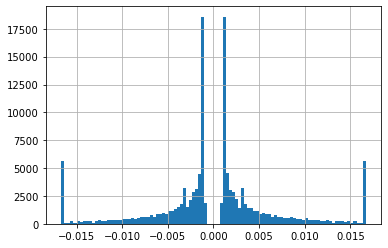

In [12]:
y = (-1)**df["win_target"]
# restrict btw 1 and 25 minutes (length of a title fight)
# short fight times -> big outliers
clipped_time_dur = df["fight_time"].clip(60, (5*5*60))
df["signed_inverse_fight_time"] = y / clipped_time_dur
df["signed_inverse_sqrt_fight_time"] = y / np.sqrt(clipped_time_dur)
df["signed_inverse_log_fight_time"] = y / np.log(clipped_time_dur)

df["signed_inverse_fight_time"].hist(bins=100)

In [13]:
from model.mma_features import RealEloWrapper

real_elo_target_cols = [
#     "fighter_result_time_left", 
#     "ml_logit_mvmt",
    # "ordinal_fighter_result",
    # "submission_fighter_result",
    # "tko_ko_fighter_result",
    # "decision_fighter_result",
    # "finish_fighter_result",
    "signed_inverse_fight_time",
    # "signed_inverse_sqrt_fight_time",
    # "signed_inverse_log_fight_time",
]
diff_elo_target_cols = [
]

binary_elo_target_cols = ["win_target", "win_target_finish"]

elo_alphas = {
    col: real_elo_alpha 
    for col in (real_elo_target_cols + diff_elo_target_cols)
}
# elo_alphas["ml_logit_mvmt"] = 0.225

real_ew = RealEloWrapper(elo_alphas=elo_alphas)
real_elo_feat_df = real_ew.fit_transform_all(df)
print(real_elo_feat_df.shape)
real_elo_feat_df.head()

elo_alphas = {
    col: bin_elo_alpha for col in binary_elo_target_cols
}
bin_ew = BinaryEloWrapper(elo_alphas=elo_alphas)
bin_elo_feat_df = bin_ew.fit_transform_all(df)
print(bin_elo_feat_df.shape)
bin_elo_feat_df.head()
# feat_ml_df["log_height_diff"] = np.log(feat_ml_df["imp_height"]) - np.log(feat_ml_df["imp_height_opp"])
# feat_ml_df["log_age_diff"] = np.log(feat_ml_df["age"]) - np.log(feat_ml_df["age_opp"])
# feat_ml_df["log_reach_diff"] = np.log(feat_ml_df["imp_reach"]) - np.log(feat_ml_df["imp_reach_opp"])
# feat_ml_df["log_reach_diff"] = feat_ml_df["log_reach_diff"].fillna(0)

getting elo features for signed_inverse_fight_time


100%|██████████| 5182/5182 [00:06<00:00, 778.02it/s]


(132600, 9)
getting elo features for win_target


100%|██████████| 5182/5182 [00:06<00:00, 770.63it/s]


getting elo features for win_target_finish


100%|██████████| 5182/5182 [00:06<00:00, 764.63it/s]


(132600, 15)


,FighterID_espn,OpponentID_espn,fight_id,win_target,pred_elo_win_target,fighter_elo_win_target,opponent_elo_win_target,updated_fighter_elo_win_target,updated_opponent_elo_win_target,win_target_finish,pred_elo_win_target_finish,fighter_elo_win_target_finish,opponent_elo_win_target_finish,updated_fighter_elo_win_target_finish,updated_opponent_elo_win_target_finish
0,2558095,2354059,1991-09-26_2354059_2558095,0.0,0.5,0.0,0.0,-0.1125,0.1125,0.0,0.5,0.0,0.0,-0.1125,0.1125
1,2354059,2558095,1991-09-26_2354059_2558095,1.0,0.5,0.0,0.0,0.1125,-0.1125,1.0,0.5,0.0,0.0,0.1125,-0.1125
2,2354119,2501396,1992-01-01_2354119_2501396,1.0,0.5,0.0,0.0,0.1125,-0.1125,1.0,0.5,0.0,0.0,0.1125,-0.1125
3,2501396,2354119,1992-01-01_2354119_2501396,0.0,0.5,0.0,0.0,-0.1125,0.1125,0.0,0.5,0.0,0.0,-0.1125,0.1125
4,3107994,2354132,1993-08-29_2354132_3107994,0.0,0.5,0.0,0.0,-0.1125,0.1125,0.0,0.5,0.0,0.0,-0.1125,0.1125


In [14]:
elo_feat_df = df.merge(
    pca_elo_feat_df, 
    how="left", 
    on=["fight_id", "FighterID_espn", "OpponentID_espn"],
).merge(
    real_elo_feat_df.drop(columns=real_elo_target_cols),
    how="left",
    on=["fight_id", "FighterID_espn", "OpponentID_espn"],
).merge(
    bin_elo_feat_df.drop(columns=binary_elo_target_cols),
    how="left",
    on=["fight_id", "FighterID_espn", "OpponentID_espn"],
)
print(elo_feat_df.shape)

(132600, 359)


In [15]:
elo_feat_df.notnull().sum()

fight_id                                  132600
Date                                      132600
FighterResult                             132476
Decision                                  132476
Rnd                                       132600
                                           ...  
pred_elo_win_target_finish                132600
fighter_elo_win_target_finish             132600
opponent_elo_win_target_finish            132600
updated_fighter_elo_win_target_finish     132600
updated_opponent_elo_win_target_finish    132600
Length: 359, dtype: int64

# Simpler features

In [16]:
from model.mma_elo_model import unknown_fighter_id
from tqdm import tqdm


def get_simple_features(df):
    # simple things that i needn't get from the fighter stats page
    # eg number of fights, t_since_last_fight
    assert (df["fight_id"].value_counts() == 2).all()
    df = df.assign(
        is_ufc=df["Event"].fillna("").str.contains("UFC"),
        Date=pd.to_datetime(df["Date"]),
    )
    feat_df = df.sort_values("Date").copy()[[
        "fight_id", "FighterID_espn", "OpponentID_espn", "Date", "is_ufc"
    ]]
    # Rolling features over fighter_careers
    # because the data is doubled, we can simply group by the fighter id
    feat_df["dummy"] = 1
    # total fights
    feat_df["total_fights"] = feat_df.groupby("FighterID_espn")["dummy"].cumsum()
    feat_df["total_fights_opp"] = feat_df.groupby("OpponentID_espn")["dummy"].cumsum()
    # total ufc fights
    feat_df["total_ufc_fights"] = feat_df.groupby("FighterID_espn")["is_ufc"].cumsum()
    feat_df["total_ufc_fights_opp"] = feat_df.groupby("OpponentID_espn")["is_ufc"].cumsum()
    # time since last fight
    feat_df["t_since_last_fight"] = feat_df.groupby("FighterID_espn")["Date"].diff().dt.days
    feat_df["t_since_last_fight_opp"] = feat_df.groupby("OpponentID_espn")["Date"].diff().dt.days
    fill_val = 2*365 # arbitrarily say 2 years
    feat_df["t_since_last_fight"] = np.maximum(fill_val, feat_df["t_since_last_fight"].fillna(fill_val))   
    feat_df["t_since_last_fight_opp"] = np.maximum(fill_val, feat_df["t_since_last_fight_opp"].fillna(fill_val)) 
    # time since first fight
    feat_df["t_since_first_fight"] = (feat_df["Date"] - feat_df.groupby("FighterID_espn")["Date"].transform("min")).dt.days
    feat_df["t_since_first_fight_opp"] = (feat_df["Date"] - feat_df.groupby("OpponentID_espn")["Date"].transform("min")).dt.days
    # compute diffs
    feat_df["t_since_last_fight_diff"] = (feat_df["t_since_last_fight"] - 
                                            feat_df["t_since_last_fight_opp"])
    feat_df["t_since_last_fight_log_diff"] = (np.log(feat_df["t_since_last_fight"]) - 
                                                np.log(feat_df["t_since_last_fight_opp"]))
    feat_df["total_fights_diff"] = (feat_df["total_fights"] - 
                                    feat_df["total_fights_opp"])
    feat_df["total_fights_sqrt_diff"] = (np.sqrt(feat_df["total_fights"]) - 
                                        np.sqrt(feat_df["total_fights_opp"]))
    feat_df["total_ufc_fights_diff"] = (feat_df["total_ufc_fights"] - 
                                        feat_df["total_ufc_fights_opp"])
    feat_df["total_ufc_fights_sqrt_diff"] = (np.sqrt(feat_df["total_ufc_fights"]) - 
                                                np.sqrt(feat_df["total_ufc_fights_opp"]))
    return feat_df

simple_feat_df = get_simple_features(elo_feat_df)
print(simple_feat_df.shape, elo_feat_df.shape)

(132600, 20) (132600, 359)


In [17]:
simple_feat_df.columns

Index(['fight_id', 'FighterID_espn', 'OpponentID_espn', 'Date', 'is_ufc',
       'dummy', 'total_fights', 'total_fights_opp', 'total_ufc_fights',
       'total_ufc_fights_opp', 't_since_last_fight', 't_since_last_fight_opp',
       't_since_first_fight', 't_since_first_fight_opp',
       't_since_last_fight_diff', 't_since_last_fight_log_diff',
       'total_fights_diff', 'total_fights_sqrt_diff', 'total_ufc_fights_diff',
       'total_ufc_fights_sqrt_diff'],
      dtype='object')

In [18]:
feat_ml_df = elo_feat_df.merge(
    simple_feat_df, 
    how="left",
    on=["FighterID_espn", "OpponentID_espn", "Date"],
    suffixes=("_legacy", ""),
)

feat_ml_df["age_diff"] = (feat_ml_df["DOB"] - feat_ml_df["DOB_opp"]).dt.days / 365
feat_ml_df["age_diff"] = feat_ml_df["age_diff"].fillna(0)

feat_ml_df["log_reach_diff"] = (
    np.log(feat_ml_df["ReachInches"]) - np.log(feat_ml_df["ReachInches_opp"])
).fillna(0)
feat_ml_df["weight_diff"] = (
    feat_ml_df["min_weight"] - feat_ml_df["min_weight_opp"]
).fillna(0)
feat_ml_df["height_diff"] = (
    feat_ml_df["HeightInches"] - feat_ml_df["HeightInches_opp"]
).fillna(0)

feat_ml_df["t_since_first_fight_diff"] = (
    feat_ml_df["t_since_first_fight"] - feat_ml_df["t_since_first_fight_opp"]
).fillna(0)
feat_ml_df["log_t_since_first_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_first_fight"]) - 
    np.log(1 + feat_ml_df["t_since_first_fight_opp"])
).fillna(0)

feat_ml_df["log_t_since_prev_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_prev_fight"]) -
    np.log(1 + feat_ml_df["t_since_prev_fight_opp"])
).fillna(0)

real_elo_target_cols = [
#     "fighter_result_time_left", 
#     "ml_logit_mvmt",
#     "ordinal_fighter_result",
#     "submission_fighter_result",
#     "tko_ko_fighter_result",
#     "decision_fighter_result",
    "signed_inverse_fight_time",
    # "finish_fighter_result",
    # *[col for col in stat_pca_df.columns 
    #   if col not in ["FighterID_espn", "OpponentID_espn", "Date"]],
]

feat_cols = [
    *[f"pred_elo_PC_{i}" for i in range(n_pca)],

    *["pred_elo_"+c for c in [*diff_elo_target_cols, 
                               *real_elo_target_cols, 
                               *binary_elo_target_cols]],
    
    # "t_since_last_fight_log_diff", 
#     "fights_per_day_diff",
#     "t_since_last_fight_diff",
#     "total_fights_sqrt_diff", 
#     "total_ufc_fights_diff",
    
    "age_diff", 
#     "log_age_diff",
#     "reach_diff", 
    "log_reach_diff",
    "weight_diff", 
#     "log_weight_diff",
    "height_diff",
#     "log_height_diff",
#     "ml_logit_mvmt",
    "log_t_since_prev_fight_diff",
    "log_t_since_first_fight_diff",
    "total_fights_diff",
#     "quad_log_t_since_first_fight_diff",
]

# new_feat_cols = [*feat_cols, "ml_logit"]
feat_cols

['pred_elo_PC_0',
 'pred_elo_PC_1',
 'pred_elo_PC_2',
 'pred_elo_PC_3',
 'pred_elo_PC_4',
 'pred_elo_PC_5',
 'pred_elo_PC_6',
 'pred_elo_PC_7',
 'pred_elo_PC_8',
 'pred_elo_PC_9',
 'pred_elo_PC_10',
 'pred_elo_PC_11',
 'pred_elo_PC_12',
 'pred_elo_PC_13',
 'pred_elo_signed_inverse_fight_time',
 'pred_elo_win_target',
 'pred_elo_win_target_finish',
 'age_diff',
 'log_reach_diff',
 'weight_diff',
 'height_diff',
 'log_t_since_prev_fight_diff',
 'log_t_since_first_fight_diff',
 'total_fights_diff']

In [19]:
feat_ml_df.columns[feat_ml_df.columns.str.contains("pred_")]

Index(['pred_elo_PC_0', 'pred_elo_PC_1', 'pred_elo_PC_2', 'pred_elo_PC_3',
       'pred_elo_PC_4', 'pred_elo_PC_5', 'pred_elo_PC_6', 'pred_elo_PC_7',
       'pred_elo_PC_8', 'pred_elo_PC_9', 'pred_elo_PC_10', 'pred_elo_PC_11',
       'pred_elo_PC_12', 'pred_elo_PC_13',
       'pred_elo_signed_inverse_fight_time', 'pred_elo_win_target',
       'pred_elo_win_target_finish'],
      dtype='object')

In [20]:
# checking to see how much data we have for each feature
feat_ml_df[feat_cols].notnull().sum()

pred_elo_PC_0                         132600
pred_elo_PC_1                         132600
pred_elo_PC_2                         132600
pred_elo_PC_3                         132600
pred_elo_PC_4                         132600
pred_elo_PC_5                         132600
pred_elo_PC_6                         132600
pred_elo_PC_7                         132600
pred_elo_PC_8                         132600
pred_elo_PC_9                         132600
pred_elo_PC_10                        132600
pred_elo_PC_11                        132600
pred_elo_PC_12                        132600
pred_elo_PC_13                        132600
pred_elo_signed_inverse_fight_time    132600
pred_elo_win_target                   132600
pred_elo_win_target_finish            132600
age_diff                              132600
log_reach_diff                        132600
weight_diff                           132600
height_diff                           132600
log_t_since_prev_fight_diff           132600
log_t_sinc

In [21]:
feat_ml_df = feat_ml_df.drop_duplicates(subset=["fight_id"])
print(feat_ml_df[feat_cols].notnull().sum())
feat_ml_df.shape

pred_elo_PC_0                         66300
pred_elo_PC_1                         66300
pred_elo_PC_2                         66300
pred_elo_PC_3                         66300
pred_elo_PC_4                         66300
pred_elo_PC_5                         66300
pred_elo_PC_6                         66300
pred_elo_PC_7                         66300
pred_elo_PC_8                         66300
pred_elo_PC_9                         66300
pred_elo_PC_10                        66300
pred_elo_PC_11                        66300
pred_elo_PC_12                        66300
pred_elo_PC_13                        66300
pred_elo_signed_inverse_fight_time    66300
pred_elo_win_target                   66300
pred_elo_win_target_finish            66300
age_diff                              66300
log_reach_diff                        66300
weight_diff                           66300
height_diff                           66300
log_t_since_prev_fight_diff           66300
log_t_since_first_fight_diff    

(66300, 383)

# Model evaluation - opening line

In [22]:
p_fighter_implied_col = "p_fighter_open_implied"

In [23]:
from model.mma_log_reg_stan import SimpleSymmetricModel

mod = SimpleSymmetricModel(
    feat_cols=feat_cols, target_col="win_target", 
    p_fighter_implied_col=p_fighter_implied_col,
    beta_prior_std=1.0, mcmc=False
)

In [24]:
from model_selection.cross_val_pipeline import TimeSeriesCrossVal

tscv = TimeSeriesCrossVal(min_test_date=pd.to_datetime("2021-01-01"), 
                          n_dates_per_fold=1, 
                          p_fighter_implied_col=p_fighter_implied_col)
preds_df = tscv.get_cross_val_preds(
    mod, 
    feat_ml_df.dropna(subset=[
        *feat_cols, "win_target", p_fighter_implied_col,
    ])
)

training on date range: 2007-07-07 2020-12-31
Initial log joint probability = -17814.7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       -5884.6    0.00106552       1.19991           1           1       22   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      21      -5884.59   0.000584856     0.0522077           1           1       24   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-07-07 2021-01-16
Initial log joint probability = -20024.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -5892.56    0.00102651      0.806802      0.8685      0.8685       22   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      22      -5892.56   0.000136413     0.0509894           1           1       25   
Opti

In [25]:
mod_pred = preds_df["y_pred"].round()
ml_pred = preds_df[p_fighter_implied_col].round()
print("Model accuracy:     ", (mod_pred == preds_df["win_target"]).mean())
print("Moneyline accuracy: ", (ml_pred == preds_df["win_target"]).mean())

Model accuracy:      0.6836803223640027
Moneyline accuracy:  0.6672263263935527


In [26]:
from sklearn.metrics import log_loss

xce = log_loss(y_true=preds_df["win_target"], y_pred=preds_df["y_pred"])
xce_ml = log_loss(y_true=preds_df["win_target"], y_pred=preds_df[p_fighter_implied_col])

print(f"model log loss    : {xce}")
print(f"Moneyline log loss: {xce_ml}")

model log loss    : 0.5849854245944446
Moneyline log loss: 0.6075945678391452


In [27]:
list(zip(mod.feat_cols, mod.fit['beta']))

[('pred_elo_PC_0', 0.12375268110876975),
 ('pred_elo_PC_1', 0.0073846793432936165),
 ('pred_elo_PC_2', -0.010037716962005578),
 ('pred_elo_PC_3', -0.014633825716334366),
 ('pred_elo_PC_4', -0.026649594661104455),
 ('pred_elo_PC_5', -0.012723889476486672),
 ('pred_elo_PC_6', 0.012962998224461597),
 ('pred_elo_PC_7', -0.023447238659502514),
 ('pred_elo_PC_8', 0.0005329091932018466),
 ('pred_elo_PC_9', 0.016698348852963917),
 ('pred_elo_PC_10', -0.016936352466691458),
 ('pred_elo_PC_11', -0.004533861197801514),
 ('pred_elo_PC_12', 0.018461214526168838),
 ('pred_elo_PC_13', 0.04641523444394513),
 ('pred_elo_signed_inverse_fight_time', -0.06764203532055892),
 ('pred_elo_win_target', 0.4474520194622384),
 ('pred_elo_win_target_finish', -0.37681827268260487),
 ('age_diff', 0.2511815204068709),
 ('log_reach_diff', 0.04216476665551554),
 ('weight_diff', 0.008904928716284566),
 ('height_diff', 0.020939912938396178),
 ('log_t_since_prev_fight_diff', -0.15816663683039367),
 ('log_t_since_first_fig

In [28]:
preds_df["week"] = preds_df["Date"].dt.isocalendar().week

In [29]:
fighter_ml_col = "FighterOpen"
opponent_ml_col = "OpponentOpen"

overall winnings


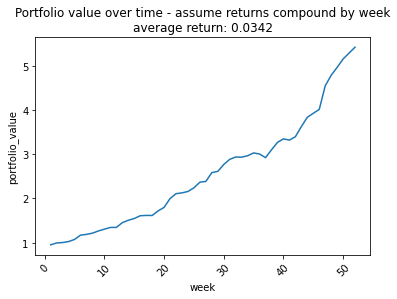

ufc winnings


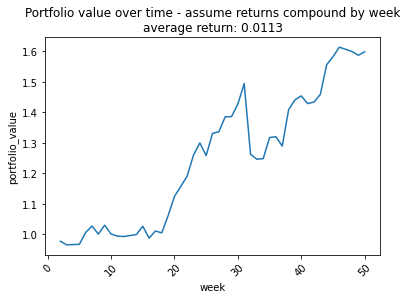

non-ufc winnings


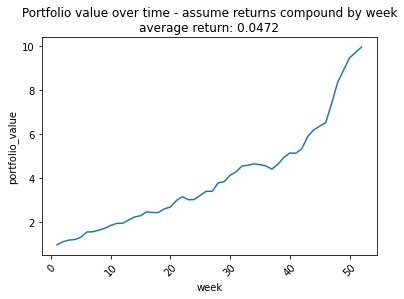

In [30]:
from model_selection.metrics import MultiKellyPM

kwargs = {
    "max_bankroll_fraction": 0.05,
    "groupby_col": "week",
    "fighter_ml_col": fighter_ml_col,
    "opponent_ml_col": opponent_ml_col,
}

print("overall winnings")
pm = MultiKellyPM(preds_df, **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("ufc winnings")
pm = MultiKellyPM(preds_df.query("is_ufc == 1"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("non-ufc winnings")
pm = MultiKellyPM(preds_df.query("is_ufc == 0"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

# Model evaluation - BetMGM, DraftKings, BetFair

I think something's fishy here, this can't be right

In [31]:
close_df = base_db_interface.read("clean_bfo_close_data")
# double the data
fighter_cols = [c for c in close_df.columns if c.endswith("_fighter")]
opponent_cols = [c[:-len("_fighter")] + "_opponent" for c in fighter_cols]
for col in fighter_cols + opponent_cols:
    close_df[col] = close_df[col].str.replace("▲", "")\
        .str.replace("▼", "")\
        .astype(float)
    
close_df_complement = close_df.rename(columns={
    "FighterID": "OpponentID",
    "OpponentID": "FighterID",
    **{f: o for f, o in zip(fighter_cols, opponent_cols)},
    **{o: f for f, o in zip(fighter_cols, opponent_cols)},
})
close_df = pd.concat([close_df, close_df_complement], axis=0)\
    .drop_duplicates(subset=["FighterID", "OpponentID", "EventHref"])\
    .dropna(subset=["FighterID", "OpponentID", "EventHref"])\
    .rename(columns={"FighterID": "FighterID_bfo", "OpponentID": "OpponentID_bfo"})\
    .drop(columns=["FighterName", "OpponentName"])\
    .reset_index(drop=True)

print(close_df.shape)
close_df.isnull().mean()

(16196, 26)


match_id               0.000000
EventHref              0.000000
DraftKings_fighter     0.764263
BetMGM_fighter         0.795258
Caesars_fighter        0.788837
BetRivers_fighter      0.865275
FanDuel_fighter        0.766980
PointsBet_fighter      0.903680
Unibet_fighter         0.815140
BetWay_fighter         0.660040
5D_fighter             0.083107
Ref_fighter            0.018400
FighterID_bfo          0.000000
Bet365_fighter         0.904791
DraftKings_opponent    0.764263
BetMGM_opponent        0.795258
Caesars_opponent       0.788837
BetRivers_opponent     0.865275
FanDuel_opponent       0.766980
PointsBet_opponent     0.903680
Unibet_opponent        0.815140
BetWay_opponent        0.660040
5D_opponent            0.083107
Ref_opponent           0.018400
OpponentID_bfo         0.000000
Bet365_opponent        0.904791
dtype: float64

In [32]:
preds_df["FighterID_bfo"]

122596        Carlos-Felipe-7484
122597             Wu-Yanan-8993
122598         David-Zawada-5347
122601      Dusko-Todorovic-9397
122602      Joaquin-Buckley-6458
                   ...          
132456         Randi-Field-12666
132459    Christian-Edwards-8986
132460        Sara-Collins-15532
132462      Adam-Piccolotti-5863
132466    Brandon-Carrillo-15533
Name: FighterID_bfo, Length: 2978, dtype: object

In [33]:
aug_preds_df = preds_df.merge(
    close_df,
    how="left",
    on=["FighterID_bfo", "OpponentID_bfo", "EventHref"],
)
aug_preds_df.isnull().mean()

fight_id_legacy    0.000000
Date               0.000000
FighterResult      0.000000
Decision           0.000000
Rnd                0.000000
                     ...   
Unibet_opponent    0.574547
BetWay_opponent    0.268972
5D_opponent        0.416387
Ref_opponent       0.269308
Bet365_opponent    0.801545
Length: 409, dtype: float64

In [34]:
close_df[["DraftKings_fighter", "BetMGM_fighter"]]

,DraftKings_fighter,BetMGM_fighter
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
16191,-365.0,-450.0
16192,NaN,-450.0
16193,-435.0,-450.0
16194,575.0,600.0


In [35]:
preds_df[fighter_ml_col]

122596   -115.0
122597   -240.0
122598    180.0
122601   -150.0
122602   -275.0
          ...  
132456   -300.0
132459   -500.0
132460   -105.0
132462   -150.0
132466    500.0
Name: FighterOpen, Length: 2978, dtype: float64

overall winnings


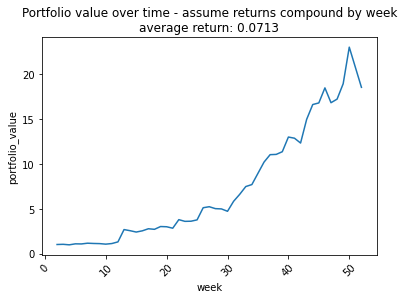

ufc winnings


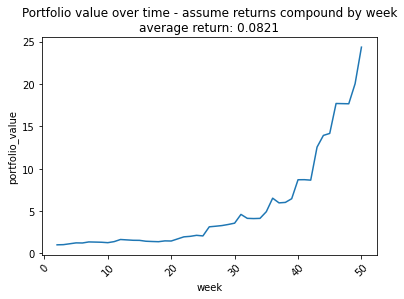

non-ufc winnings


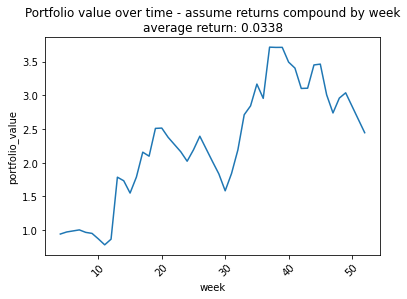

In [36]:
market = "DraftKings"
# market = "BetMGM"

kwargs = {
    "max_bankroll_fraction": 1,
    "groupby_col": "week",
    "fighter_ml_col": f"{market}_fighter",
    "opponent_ml_col": f"{market}_opponent",
}

temp_preds_df = aug_preds_df.dropna(subset=[
    f"{market}_fighter", f"{market}_opponent"
])
temp_preds_df

print("overall winnings")
pm = MultiKellyPM(temp_preds_df, **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("ufc winnings")
pm = MultiKellyPM(temp_preds_df.query("is_ufc == 1"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("non-ufc winnings")
pm = MultiKellyPM(temp_preds_df.query("is_ufc == 0"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

# Predictions for upcoming fights

In [37]:
mod = SimpleSymmetricModel(
    feat_cols=feat_cols, target_col="win_target", 
    p_fighter_implied_col=p_fighter_implied_col,
    beta_prior_std=1.0, mcmc=False
)
preds_df = tscv.get_cross_val_preds(
    mod, 
    feat_ml_df.dropna(subset=[
        *feat_cols, "win_target", p_fighter_implied_col,
    ])
)

training on date range: 2007-07-07 2020-12-31
Initial log joint probability = -19729.1
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -5884.59   0.000496996      0.527152      0.7943      0.7943       20   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      21      -5884.59   0.000112705     0.0920109           1           1       22   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-07-07 2021-01-16
Initial log joint probability = -24163.6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -5892.56   0.000741631      0.485506           1           1       21   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      21      -5892.56   0.000536126      0.122592           1           1       23   
Opti

In [38]:
from wrangle.clean_bfo_data import parse_american_odds

main_card_df = [
    ("Israel Adesanya", "Alex Pereira", "-150", "+130"),
    ("Gilbert Burns", "Jorge Masvidal", "-500", "+400"),
    ("Adrian Yanez", "Rob Font", "-185", "+160"),
    ("Kevin Holland", "Santiago Ponzinibbio", "-200", "+170"),
    ("Christian Rodriguez", "Raul Rosas Jr.", "+210", "-250"),
]
main_card_df = pd.DataFrame(
    main_card_df, 
    columns=["FighterName_ufc", "OpponentName_ufc", 
             "FighterOpen", "OpponentOpen"],
)
main_card_df_complement = main_card_df.rename(columns={
    "FighterName_ufc": "OpponentName_ufc",
    "OpponentName_ufc": "FighterName_ufc",
    "FighterOpen": "OpponentOpen",
    "OpponentOpen": "FighterOpen",
})
main_card_df = pd.concat([
    main_card_df,
    main_card_df_complement,
]).reset_index(drop=True)
main_card_df

,FighterName_ufc,OpponentName_ufc,FighterOpen,OpponentOpen
0,Israel Adesanya,Alex Pereira,-150,+130
1,Gilbert Burns,Jorge Masvidal,-500,+400
2,Adrian Yanez,Rob Font,-185,+160
3,Kevin Holland,Santiago Ponzinibbio,-200,+170
4,Christian Rodriguez,Raul Rosas Jr.,+210,-250
5,Alex Pereira,Israel Adesanya,+130,-150
6,Jorge Masvidal,Gilbert Burns,+400,-500
7,Rob Font,Adrian Yanez,+160,-185
8,Santiago Ponzinibbio,Kevin Holland,+170,-200
9,Raul Rosas Jr.,Christian Rodriguez,-250,+210


In [39]:
train_df = feat_ml_df.query("is_ufc == 1 & is_upcoming == 0")\
    .dropna(subset=[
        *feat_cols, "win_target", p_fighter_implied_col
    ])
test_df = feat_ml_df.query("is_upcoming == 1 & Date == '2023-04-08'").copy()
test_df = test_df.drop(columns=["FighterOpen", "OpponentOpen"]).merge(
    main_card_df,
    how="inner",
    on=["FighterName_ufc", "OpponentName_ufc"],
)
p_fighter = parse_american_odds(test_df["FighterOpen"])
p_opponent = parse_american_odds(test_df["OpponentOpen"])
test_df["p_fighter_open_implied"] = p_fighter / (p_fighter + p_opponent)
test_df
# test_df[p_fighter_implied_col] = test_df[p_fighter_implied_col].fillna(0.5)
train_df.shape, test_df.shape

((5844, 383), (5, 383))

In [40]:
test_df[["FighterName_ufc", "OpponentName_ufc"]]

,FighterName_ufc,OpponentName_ufc
0,Israel Adesanya,Alex Pereira
1,Rob Font,Adrian Yanez
2,Gilbert Burns,Jorge Masvidal
3,Santiago Ponzinibbio,Kevin Holland
4,Christian Rodriguez,Raul Rosas Jr.


In [41]:
bfo_to_ufc_map = base_db_interface.read("bfo_to_ufc_map")
bfo_to_ufc_map

,FighterID_bfo,OpponentID_bfo,Date,FighterID_ufc,OpponentID_ufc
0,A-J-Dobson-10772,Armen-Petrosyan-11514,2022-10-22 00:00:00,009c4420727149ea,369ea36e450ae62a
1,A-J-Fletcher-12271,Themba-Gorimbo-12770,2023-02-18 00:00:00,725b1abc9a39d873,40f3cb27fc7305a1
2,A-J-Fletcher-12271,Ange-Loosa-9074,2022-08-20 00:00:00,725b1abc9a39d873,1497e735d9f2560a
3,A-J-Fletcher-12271,Matthew-Semelsberger-10268,2022-03-12 00:00:00,725b1abc9a39d873,4aa58269d0664b5b
4,A-J-Fletcher-12271,Leonardo-Damiani-10527,2021-08-31 00:00:00,725b1abc9a39d873,acd870570949d8a2
...,...,...,...,...,...
15043,Zubaira-Tukhugov-5054,Renato-Moicano-5598,2016-05-14 00:00:00,aceffa19749c4dc0,b6452706b373eea1
15044,Zubaira-Tukhugov-5054,Phillipe-Nover-985,2015-12-10 00:00:00,aceffa19749c4dc0,64360e618823a8e4
15045,Zubaira-Tukhugov-5054,Ernest-Chavez-4689,2014-10-04 00:00:00,aceffa19749c4dc0,b406da701c479076
15046,Zubaira-Tukhugov-5054,Kevin-Aguilar-2365,2020-02-22 00:00:00,aceffa19749c4dc0,cf946e03ba2e7666


In [42]:
ufc_df = close_df.query("EventHref == '/events/ufc-287-2760'")
print(ufc_df.shape)
ufc_df = ufc_df.merge(
    bfo_to_ufc_map[["FighterID_bfo", "FighterID_ufc"]].drop_duplicates(), 
    how="left", 
    on=["FighterID_bfo"]
).merge(
    bfo_to_ufc_map[["OpponentID_bfo", "OpponentID_ufc"]].drop_duplicates(),
    how="left",
    on=["OpponentID_bfo"]
)
print(ufc_df.shape)
ufc_df

(24, 26)
(24, 28)


,match_id,EventHref,DraftKings_fighter,BetMGM_fighter,Caesars_fighter,BetRivers_fighter,FanDuel_fighter,PointsBet_fighter,Unibet_fighter,BetWay_fighter,...,FanDuel_opponent,PointsBet_opponent,Unibet_opponent,BetWay_opponent,5D_opponent,Ref_opponent,OpponentID_bfo,Bet365_opponent,FighterID_ufc,OpponentID_ufc
0,0.0,/events/ufc-287-2760,-450.0,-450.0,-475.0,-455.0,-490.0,NaN,NaN,-450.0,...,380.0,NaN,NaN,333.0,NaN,340.0,Jorge-Masvidal-99,350.0,23024fdfc966410a,47b9e0e7703a4868
1,1.0,/events/ufc-287-2760,NaN,-190.0,-180.0,-190.0,-180.0,NaN,-190.0,-188.0,...,152.0,NaN,150.0,150.0,NaN,162.0,Rob-Font-4984,150.0,0232cabbc30a2372,05339613bf8e9808
2,2.0,/events/ufc-287-2760,NaN,-250.0,-260.0,-250.0,-250.0,NaN,-250.0,-250.0,...,205.0,NaN,195.0,200.0,NaN,195.0,Santiago-Ponzinibbio-4415,200.0,3a46b268013afede,6d1bffff14897645
3,3.0,/events/ufc-287-2760,NaN,200.0,220.0,195.0,198.0,NaN,195.0,200.0,...,-240.0,NaN,-250.0,-250.0,NaN,-230.0,Raul-Rosas-Jr-14405,-225.0,NaN,NaN
4,4.0,/events/ufc-287-2760,NaN,120.0,115.0,110.0,108.0,NaN,110.0,100.0,...,-130.0,NaN,-137.0,-125.0,NaN,-141.0,Kelvin-Gastelum-4061,-138.0,5442f1bc4b47eaf3,8c0580d4fff106c1
5,5.0,/events/ufc-287-2760,NaN,-165.0,-170.0,-167.0,-166.0,NaN,-167.0,-163.0,...,140.0,NaN,133.0,130.0,NaN,145.0,Michelle-Waterson-3944,140.0,a3a542074109b347,eb04b9d31e938edb
6,6.0,/events/ufc-287-2760,NaN,160.0,170.0,155.0,168.0,NaN,155.0,160.0,...,-200.0,NaN,-200.0,-200.0,NaN,-185.0,Joe-Pyfer-8530,-188.0,6ac9bc2953c47345,c1085e1701b13eca
7,7.0,/events/ufc-287-2760,NaN,310.0,325.0,325.0,350.0,NaN,325.0,333.0,...,-450.0,NaN,-435.0,-450.0,NaN,-420.0,Karl-Williams-13254,-500.0,01b352b6a9074d5c,d35f734c56a89103
8,8.0,/events/ufc-287-2760,NaN,240.0,235.0,225.0,235.0,NaN,225.0,210.0,...,-290.0,NaN,-295.0,-275.0,NaN,-251.0,Lupita-Godinez-9456,-300.0,98215d037be5bcb7,8e5d953bdb9ae5e7
9,9.0,/events/ufc-287-2760,NaN,-375.0,-360.0,-345.0,-330.0,NaN,-345.0,-350.0,...,265.0,NaN,265.0,260.0,NaN,330.0,Trey-Ogden-5784,275.0,e4a47b07044ddd72,cfc3e7bb44685289


In [43]:
aug_test_df = test_df.merge(
    ufc_df,
    how="left",
    on=["FighterID_ufc", "OpponentID_ufc"],
)
aug_test_df

,fight_id_legacy,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,Caesars_opponent,BetRivers_opponent,FanDuel_opponent,PointsBet_opponent,Unibet_opponent,BetWay_opponent,5D_opponent,Ref_opponent,OpponentID_bfo_y,Bet365_opponent
0,2023-04-08_4285679_4705658,2023-04-08,None,None,-,-,None,4705658,4285679,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-08_3090451_3998248,2023-04-08,None,None,-,-,None,3998248,3090451,NaN,...,-180.0,-190.0,-180.0,NaN,-190.0,-188.0,NaN,-187.0,Adrian-Yanez-4952,-175.0
2,2023-04-08_2500857_3090197,2023-04-08,None,None,-,-,None,2500857,3090197,NaN,...,350.0,350.0,380.0,NaN,NaN,333.0,NaN,340.0,Jorge-Masvidal-99,350.0
3,2023-04-08_3043484_3943695,2023-04-08,None,None,-,-,None,3943695,3043484,NaN,...,-260.0,-250.0,-250.0,NaN,-250.0,-250.0,NaN,-230.0,Kevin-Holland-5910,-250.0
4,2023-04-08_4875511_5088844,2023-04-08,None,None,-,-,None,5088844,4875511,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# aug_test_df["p_fighter_open_implied"]# = aug_test_df["p_fighter_open_implied"].fillna(0.5)
aug_test_df.columns[aug_test_df.columns.str.contains("p_fighter_open_implied")]

Index(['p_fighter_open_implied'], dtype='object')

In [45]:
mod = SimpleSymmetricModel(
    feat_cols=feat_cols, target_col="win_target", 
    p_fighter_implied_col=p_fighter_implied_col,
    beta_prior_std=1.0, mcmc=False
)

y_pred = mod.fit_predict(train_df, aug_test_df, feat_cols)
y_pred

Initial log joint probability = -12117.3


array([0.66803115, 0.44904611, 0.79482079, 0.41698666, 0.32474906])

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -3600.04    0.00190042      0.692314           1           1       23   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      22      -3600.04   0.000154794     0.0770077           1           1       26   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [46]:
from scipy.special import logit, expit
preds_df = aug_test_df.assign(
    y_pred = y_pred,
    # bet_dir = logit(y_pred) - logit(0.5)
)
preds_df[[
    "FighterName_ufc", "OpponentName_ufc", 
    p_fighter_implied_col, 
    "y_pred", "Date",
    # "DraftKings_fighter", "DraftKings_opponent",
    "BetMGM_fighter", "BetMGM_opponent",
    "Caesars_fighter", "Caesars_opponent",
    "FanDuel_fighter", "FanDuel_opponent",
]]

for col in [
        "BetMGM_fighter", "BetMGM_opponent",
    "Caesars_fighter", "Caesars_opponent",
    "FanDuel_fighter", "FanDuel_opponent",
    # "FighterOpen", "Opponent"
    ]:
    preds_df[col] = preds_df[col].astype(float)
preds_df

,fight_id_legacy,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,BetRivers_opponent,FanDuel_opponent,PointsBet_opponent,Unibet_opponent,BetWay_opponent,5D_opponent,Ref_opponent,OpponentID_bfo_y,Bet365_opponent,y_pred
0,2023-04-08_4285679_4705658,2023-04-08,None,None,-,-,None,4705658,4285679,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.668031
1,2023-04-08_3090451_3998248,2023-04-08,None,None,-,-,None,3998248,3090451,NaN,...,-190.0,-180.0,NaN,-190.0,-188.0,NaN,-187.0,Adrian-Yanez-4952,-175.0,0.449046
2,2023-04-08_2500857_3090197,2023-04-08,None,None,-,-,None,2500857,3090197,NaN,...,350.0,380.0,NaN,NaN,333.0,NaN,340.0,Jorge-Masvidal-99,350.0,0.794821
3,2023-04-08_3043484_3943695,2023-04-08,None,None,-,-,None,3943695,3043484,NaN,...,-250.0,-250.0,NaN,-250.0,-250.0,NaN,-230.0,Kevin-Holland-5910,-250.0,0.416987
4,2023-04-08_4875511_5088844,2023-04-08,None,None,-,-,None,5088844,4875511,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.324749


In [47]:
preds_df[["FighterName_ufc", "OpponentName_ufc", "y_pred", p_fighter_implied_col, "Date"]]

,FighterName_ufc,OpponentName_ufc,y_pred,p_fighter_open_implied,Date
0,Israel Adesanya,Alex Pereira,0.668031,0.579832,2023-04-08
1,Rob Font,Adrian Yanez,0.449046,0.372063,2023-04-08
2,Gilbert Burns,Jorge Masvidal,0.794821,0.806452,2023-04-08
3,Santiago Ponzinibbio,Kevin Holland,0.416987,0.357143,2023-04-08
4,Christian Rodriguez,Raul Rosas Jr.,0.324749,0.311111,2023-04-08


In [48]:
from model_selection.metrics import MultiKellyPM

pm = MultiKellyPM(preds_df,
                  fighter_ml_col="FanDuel_fighter",
                    opponent_ml_col="FanDuel_opponent",
                  parse_ml=True)
pm.get_portfolio_weights()

,fight_id,Date,y_pred,FighterID_espn,OpponentID_espn,fighter_payout,opponent_payout,fighter_bet,opponent_bet
0,2023-04-08_4285679_4705658,2023-04-08,0.668031,4285679,4705658,NaN,NaN,0.000000,0.0
1,2023-04-08_3090451_3998248,2023-04-08,0.449046,3090451,3998248,1.520000,0.555556,0.043288,0.0
2,2023-04-08_2500857_3090197,2023-04-08,0.794821,3090197,2500857,0.204082,3.800000,0.000000,0.0
3,2023-04-08_3043484_3943695,2023-04-08,0.416987,3043484,3943695,2.050000,0.400000,0.066295,0.0
4,2023-04-08_4875511_5088844,2023-04-08,0.324749,4875511,5088844,NaN,NaN,0.000000,0.0
